In [1]:
import torch
import torch.nn as nn
import math
from typing import List
from collections import OrderedDict

In [2]:
dtype = torch.float
device = torch.device("cuda:0")
torch.set_default_device(device)

In [3]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self, n_inputs: int, n_hiddens_each_layer: List[int], n_outputs: int):
    """Creates a neural network with the given structure

        Args:
        ----------
        n_inputs : int
            The number of values in each sample
        n_hiddens_each_layer : List[int]
            The number of units in each hidden layer.
            Its length specifies the number of hidden layers.
        n_outputs : int
            The number of units in output layer

        Returns
        -------
        NeuralNetwork object
        """
    super(NeuralNetwork, self).__init__()
    self.n_inputs = n_inputs
    self.n_hiddens_each_layer = n_hiddens_each_layer
    self.n_outputs = n_outputs
    self.standardized = False

    # create list of shapes of weight matrices for each layer
    shapes = self._set_shapes()
    self.shapes = shapes

    self.model = self._build_model()
    self.model.apply(self.initialize_weights)

    self.X_means = None
    self.X_stds = None
    self.T_means = None
    self.T_stds = None

    self.n_epochs = 0
    self.error_trace = []

  def _set_shapes(self, W_shapes: List[int]=[]):
    """
    Args:
        W_shapes List[int]: empty list by default, will hold shapes of weights in each layer

    Set shapes for weights in each layer.

    Returns
    -------
    List of pairs of ints: Each pair is the shape of weights in a layer.
    """
    if not self.n_hiddens_each_layer and self.n_outputs <= 0:
      raise ValueError("Network must have at least one hidden layer or valid output units.")

    num_layers = len(self.n_hiddens_each_layer)

    if num_layers >= 1:
        for layer in range(num_layers):
            units_in_layer = self.n_hiddens_each_layer[layer]
            if layer == 0:
                units_prev_layer = self.n_inputs
            else:
                units_prev_layer = self.n_hiddens_each_layer[layer - 1]
            W_shapes.append((units_prev_layer, units_in_layer)) # remove add 1 for bias, Linear takes care of it
        # shape for output layer
        W_shapes.append((self.n_hiddens_each_layer[-1], self.n_outputs))
    else:
        W_shapes.append((self.n_inputs, self.n_outputs))

    return W_shapes

  def _build_model(self, activation_fn=nn.Tanh, use_bias=True):
    """
    Dynamically builds a Sequential model based on weight shapes.

    Args:
        activation_fn (callable): Activation function class (default: nn.Tanh).
        use_bias (bool): Whether to include bias in Linear layers (default: True).

    Returns:
        nn.Sequential: A Sequential model with specified layers and activations.
    """
    layers = []
    for i, shape in enumerate(self.shapes[:-1]):
      if not isinstance(shape, (tuple, list)) or len(shape) != 2:
            raise ValueError(f"Invalid shape at index {i}: {shape}. Each shape must be a tuple of two integers.")
      layers.append((f"layer_{i}", nn.Linear(*shape)))
      # layers.append(Clamp(min=-10, max=10))  # Add clamping
      layers.append((f"activation_{i}", activation_fn()))
    # Output layer (no activation)
    layers.append((f"output_layer", nn.Linear(*self.shapes[-1])))

    return nn.Sequential(OrderedDict(layers))

  def initialize_weights(self, layer):
    """
      Create weights for each layer using Xavier initialization.
    """
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

  def _create_params(self, size, lower_limt=0, upper_limit=0.01):
    return nn.Parameter(torch.zeros(*size).normal_(lower_limt, upper_limit))

  def _create_param(self, size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

  def forward(self, x):
      """
      Defines the forward pass of the model.

      Args:
          x (torch.Tensor): Input tensor with shape (batch_size, input_features).
                            Represents the input data to the model.

      Returns:
          torch.Tensor: Output tensor after passing through the model's layers.
                        The shape depends on the final layer of the model, typically
                        (batch_size, output_features).

      This method applies the layers defined in the model sequentially to the input tensor.
      It is called automatically when the model is invoked, e.g., `output = model(input)`.
      """
      return self.model(x)

  def __repr__(self):
      return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_each_layer}, {self.n_outputs})'

In [4]:
from enum import Enum
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from typing import Optional

class Optimizer(Enum):
  SGD = 1
  ADAMW = 2

class ModelTrainer():
  def __init__(self, optimizer: Optimizer, nnet: NeuralNetwork, lr=1e-4):
    self.Optimizer = optimizer
    self.nnet = nnet
    self.lr = lr
    self.error_trace = []

  def train(
      self,
      nnet: NeuralNetwork,
      Xtrain: Tensor,
      Ttrain: Tensor,
      Xvalidate: Tensor,
      Tvalidate: Tensor,
      n_epochs: int,
      batch_size: int =-1,
      optimizer: Optional[Optimizer] = Optimizer.SGD,
      learning_rate: Optional[float] = None,
      loss_fn: torch.nn.Module = torch.nn.MSELoss(reduction='mean'),
      standardize_params: bool = True,
      verbose: bool = True
    ) -> None:
    """
    Trains the neural network model.

    Args:
    ----------
    nnet : torch.nn.Module
        The neural network to train.
    Xtrain : torch.Tensor
        Input tensor for training data.
    Ttrain : torch.Tensor
        Target tensor for training data.
    Xvalidate : torch.Tensor
        Input tensor for validation data.
    Tvalidate : torch.Tensor
        Target tensor for validation data.
    n_epochs : int
        Number of training epochs.
    batch_size : int
        Batch size for training. Use -1 for full-batch training.
    optimizer : torch.optim.Optimizer, optional
        Optimizer to use for training.
    learning_rate : float, optional
        Learning rate for the optimizer.
    standardize_params : bool
        Whether to standardize input and target parameters.
    verbose : bool
        Whether to print progress during training.

    Returns
    -------
    None
    """
    # if batch_size == -1 use all input data as batch
    nnet.batch_size = batch_size if batch_size != -1 else nnet.n_inputs

    if standardize_params:
      Xtrain, Ttrain, Xvalidate, Tvalidate, nnet.X_means, nnet.X_stds, nnet.T_means, nnet.T_stds = self._standardize(Xtrain, Ttrain, Xvalidate, Tvalidate)

    # Initialize Optimizers
    optimizer = self._initializeOptimizer()
    # loss_fn = torch.nn.MSELoss(reduction='mean')

    train_ds = TensorDataset(Xtrain, Ttrain)
    valid_ds = TensorDataset(Xvalidate, Tvalidate)
    train_dl, valid_dl = self.get_data(train_ds, valid_ds, nnet.batch_size)
    self.fit(n_epochs, nnet, loss_fn, optimizer, train_dl, valid_dl)

    print("Finished training run!")

  def fit(self, n_epochs, nnet, loss_fn, opt, train_dl, valid_dl):
    for epoch in range(n_epochs):
      nnet.train() # set to train mode
      train_total_loss, train_samples = 0.0, 0
      for X_batch, T_batch in train_dl:
        train_batch_loss, train_batch_size = self.loss_batch(nnet, loss_fn, X_batch, T_batch, opt=opt)
        train_total_loss += train_batch_loss * train_batch_size
        train_samples += train_batch_size
      train_loss = train_total_loss / train_samples

      # eval model against Validation data
      nnet.eval()  # Set model to evaluation mode
      with torch.no_grad():  # No need to compute gradients during validation
          total_loss, total_samples = 0.0, 0
          for X_batch, T_batch in valid_dl:
              batch_loss, batch_size = self.loss_batch(nnet, loss_fn, X_batch, T_batch)
              total_loss += batch_loss * batch_size
              total_samples += batch_size
      val_loss = total_loss / total_samples
      self.error_trace.append((train_loss, val_loss))

      if n_epochs >= 0 and epoch % (n_epochs // 10) == 0:
        print(f"Epoch: {epoch}, Train loss: {train_loss}, Val Loss: {val_loss}")

  def loss_batch(self, nnet, loss_func, xb, tb, opt=None):
    loss = loss_func(nnet(xb), tb)

    if opt is not None:
      # Zero gradients, perform a backward pass, and update the weights.
      loss.backward()
      opt.step()
      opt.zero_grad()

    return loss.item(), len(xb)

  def get_data(self, train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True, generator=torch.Generator(device='cuda')),
        DataLoader(valid_ds, batch_size=bs * 2)
    )

  def _standardize(self, Xtrain, Ttrain, Xvalidate, Tvalidate):
      # Calculate and assign standardization parameters
      X_means = torch.mean(Xtrain, dim=0)
      X_stds = torch.std(Xtrain, dim=0)
      X_stds[X_stds == 0] = 1  # Prevent division by zero

      T_means = torch.mean(Ttrain, dim=0)
      T_stds = torch.std(Ttrain, dim=0)
      T_stds[T_stds == 0] = 1  # Prevent division by zero

      # Standardize data
      Xtrain_std = (Xtrain - X_means) / X_stds
      Ttrain_std = (Ttrain - T_means) / T_stds
      Xvalidate_std = (Xvalidate - X_means) / X_stds
      Tvalidate_std = (Tvalidate - T_means) / T_stds

      return Xtrain_std, Ttrain_std, Xvalidate_std, Tvalidate_std, X_means, X_stds, T_means, T_stds

  def _initializeOptimizer(self):
    if self.Optimizer == Optimizer.SGD:
      optimizer = torch.optim.SGD(self.nnet.parameters(), lr=self.lr, momentum=0.001)
    elif self.Optimizer == Optimizer.ADAMW:
      optimizer = torch.optim.AdamW(self.nnet.parameters(), lr=self.lr)
    else:
      raise ValueError(f"Unsupported optimizer type: {self.Optimizer}")

    return optimizer

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.linspace(0, 10, 200).reshape(-1, 1)
T = np.sin(X)

# Split into training and validation sets
X, X_val, T, T_val = train_test_split(X, T, test_size=0.2, random_state=42)

# Print shapes to verify split
print(f"Training set: X_train {X.shape}, T_train {T.shape}")
print(f"Validation set: X_val {X_val.shape}, T_val {T_val.shape}")

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
T_tensor = torch.tensor(T, dtype=torch.float32)
Xval_tensor = torch.tensor(X_val, dtype=torch.float32)
Tval_tensor = torch.tensor(T_val, dtype=torch.float32)

X_tensor.shape, T_tensor.shape, Xval_tensor.shape, Tval_tensor.shape

Training set: X_train (160, 1), T_train (160, 1)
Validation set: X_val (40, 1), T_val (40, 1)


(torch.Size([160, 1]),
 torch.Size([160, 1]),
 torch.Size([40, 1]),
 torch.Size([40, 1]))

In [6]:
nnet = NeuralNetwork(X.shape[1], [20, 20, 10], 1)
trainer = ModelTrainer(Optimizer.SGD, nnet, 0.001)
trainer.train(nnet, X_tensor, T_tensor, Xval_tensor, Tval_tensor, n_epochs=1000, batch_size=100)

Epoch: 0, Train loss: 1.4626121371984482, Val Loss: 0.9068126678466797
Epoch: 100, Train loss: 1.0299451351165771, Val Loss: 0.8317821621894836
Epoch: 200, Train loss: 0.9794392883777618, Val Loss: 0.8777746558189392
Epoch: 300, Train loss: 0.967995896935463, Val Loss: 0.896928608417511
Epoch: 400, Train loss: 0.9606587737798691, Val Loss: 0.8984751105308533
Epoch: 500, Train loss: 0.9529200345277786, Val Loss: 0.893896758556366
Epoch: 600, Train loss: 0.9441257119178772, Val Loss: 0.8867537379264832
Epoch: 700, Train loss: 0.9336819797754288, Val Loss: 0.8785431981086731
Epoch: 800, Train loss: 0.9212989583611488, Val Loss: 0.8648893237113953
Epoch: 900, Train loss: 0.9063243940472603, Val Loss: 0.8508359789848328
Finished training run!


# More Detailed Example Use

In [7]:
# init train data as Pytorch Tensors
Xtrain = torch.arange(-2, 2, 0.05).reshape(-1, 1)
Ttrain = torch.sin(Xtrain) * torch.sin(Xtrain * 5)
# Validation data
Xval = Xtrain * 1.1
Tval = Ttrain + 0.2 * Xtrain
# Test data
Xtest = Xtrain * 0.97
Ttest = Ttrain + 0.15 * Xtrain

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

(torch.Size([80, 1]),
 torch.Size([80, 1]),
 torch.Size([80, 1]),
 torch.Size([80, 1]),
 torch.Size([80, 1]),
 torch.Size([80, 1]))

In [8]:
import matplotlib.pyplot as plt

nnet = NeuralNetwork(Xtrain.shape[1], [20, 20, 10], 1)
trainer = ModelTrainer(Optimizer.SGD, nnet, 0.1)
trainer.train(nnet, Xtrain, Ttrain, Xval, Tval, n_epochs=3000, batch_size=1000)

Epoch: 0, Train loss: 0.9893351793289185, Val Loss: 1.2236932516098022
Epoch: 300, Train loss: 0.8693985342979431, Val Loss: 0.9614979028701782
Epoch: 600, Train loss: 0.7682139277458191, Val Loss: 0.7404470443725586
Epoch: 900, Train loss: 0.30903592705726624, Val Loss: 0.5159987211227417
Epoch: 1200, Train loss: 0.299786776304245, Val Loss: 0.4124748408794403
Epoch: 1500, Train loss: 0.22864890098571777, Val Loss: 0.3002377152442932
Epoch: 1800, Train loss: 0.19121494889259338, Val Loss: 0.30453217029571533
Epoch: 2100, Train loss: 0.18611694872379303, Val Loss: 0.3341900706291199
Epoch: 2400, Train loss: 0.18299610912799835, Val Loss: 0.3578045070171356
Epoch: 2700, Train loss: 0.18699228763580322, Val Loss: 0.4157504141330719
Finished training run!


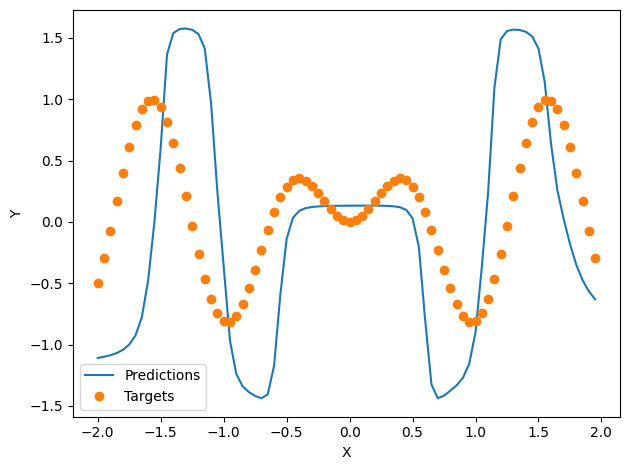

In [9]:
Ytrain = nnet(Xtrain)
plt.plot(Xtrain.cpu().detach().numpy(), Ytrain.cpu().detach().numpy(), '-', label='Predictions')
plt.plot(Xtrain.cpu().detach().numpy(), Ttrain.cpu().detach().numpy(), 'o', label='Targets')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.tight_layout()

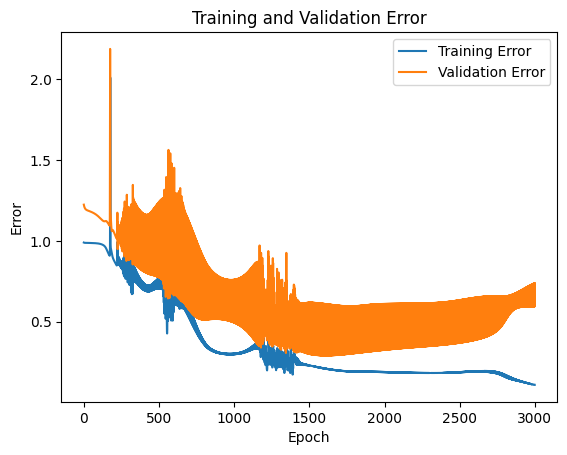

In [10]:
# Extract training and validation errors
train_errors = [entry[0] for entry in trainer.error_trace]
val_errors = [entry[1] for entry in trainer.error_trace]

# Plot the errors
plt.plot(train_errors, label="Training Error")
plt.plot(val_errors, label="Validation Error")

# Add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training and Validation Error")
plt.legend()

## Apply NeuralNetwork PyTorch Implementation to MNIST dataset

In [11]:
class ConvNeuralNetwork(nn.Module):
    def __init__(
        self,
        n_inputs: List[int],
        conv_layers: List[List[int]],
        n_outputs: int,
      ):
      """
      Creates a convolutional neural network with the given structure.

      Args:
      ------
      n_inputs : List[int]
          Image size is n_inputs x n_inputs x n_channels
      conv_layers : List[List[int]]
          Specifications of each convolutional layer.
          n_units, kernel_size, stride
      n_outputs : int
          The number of units in output layer
      """
      super().__init__()
      self.n_inputs = n_inputs
      self.conv_layers = conv_layers
      self.n_outputs = n_outputs
      self.model = self._build_model()

    def _build_model(self):
      layers = []
      prev_units = self.n_inputs[2]  # Number of input channels (e.g., 3 for RGB images)
      spatial_size = self.n_inputs[0]  # Assume square input (n_inputs[0] x n_inputs[1])

      for i, conv_layer in enumerate(self.conv_layers):
        n_units, kernel_size, stride = conv_layer

        in_channels = prev_units if i == 0 else self.conv_layers[i-1][0]
        # Add Conv2D layer
        layers.append(nn.Conv2d(in_channels=in_channels, out_channels=n_units, kernel_size=kernel_size, stride=stride))
        layers.append(nn.ReLU())

        # Update spatial dimensions
        spatial_size = (spatial_size - kernel_size) // stride + 1
        prev_units = n_units
      # Flatten layer before the fully connected layers
      layers.append(nn.Flatten())

      # Add output fully connected layer
      layers.append(nn.Linear(prev_units * spatial_size * spatial_size, self.n_outputs))
      return nn.Sequential(*layers)

    def forward(self, X):
      """
      Defines the forward pass of the model.

      Args:
          X (torch.Tensor): Input tensor with shape (batch_size, input_features).
                            Represents the input data to the model.

      Returns:
          torch.Tensor: Output tensor after passing through the model's layers.
                        The shape depends on the final layer of the model, typically
                        (batch_size, output_features).

      This method applies the layers defined in the model sequentially to the input tensor.
      It is called automatically when the model is invoked, e.g., `output = model(input)`.
      """
      X = X.view(-1, 1, 28, 28)
      return self.model(X)

    def use(self, X):
      """
      Perform inference with trained model. Predicts output and
      output tensor is converted to a singular digit prediction.

      Returns:
        int: Predicted digit.
      """
      return torch.argmax(self(X)).item()

In [12]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [13]:
# load mnist data form pickle format
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


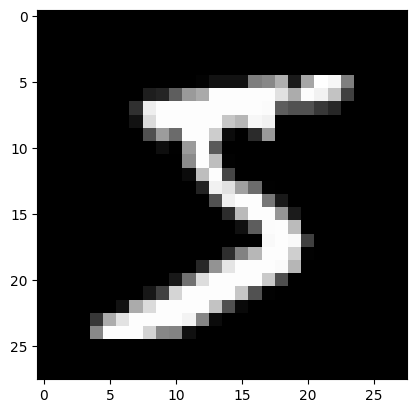

In [14]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
# ``pyplot.show()`` only if not on Colab
try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)

In [15]:
# convert input data from numpy arrays to torch tensors
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0') tensor([5, 0, 4,  ..., 8, 4, 8], device='cuda:0')
torch.Size([50000, 784])
tensor(0, device='cuda:0') tensor(9, device='cuda:0')


In [16]:
cnn = ConvNeuralNetwork([28, 28, 1], [[16, 3, 2], [16, 3, 2]], 10)
trainer = ModelTrainer(Optimizer.SGD, cnn, 0.1)
trainer.train(cnn, x_train, y_train, x_valid, y_valid, n_epochs=100, batch_size=1000, loss_fn=torch.nn.CrossEntropyLoss(), standardize_params=False)

Epoch: 0, Train loss: 1.735791312456131, Val Loss: 0.659066641330719
Epoch: 10, Train loss: 0.2099095207452774, Val Loss: 0.1919079452753067
Epoch: 20, Train loss: 0.12582250952720642, Val Loss: 0.12599812150001527
Epoch: 30, Train loss: 0.09289673313498498, Val Loss: 0.09821471422910691
Epoch: 40, Train loss: 0.07663950204849243, Val Loss: 0.0887705385684967
Epoch: 50, Train loss: 0.06638941198587417, Val Loss: 0.08063771575689316
Epoch: 60, Train loss: 0.05907389886677265, Val Loss: 0.07964821755886078
Epoch: 70, Train loss: 0.05346603747457266, Val Loss: 0.07818440943956376
Epoch: 80, Train loss: 0.04948607984930277, Val Loss: 0.0793484628200531
Epoch: 90, Train loss: 0.04571148209273815, Val Loss: 0.07394748330116271
Finished training run!


In [17]:
def eval_validation(total=1000):
  correct = 0
  for i in range(total):
    if cnn.use(x_valid[i]) == y_valid[i]:
      correct += 1
    else:
      print(f"CNN Prediction: {cnn.use(x_valid[i])}, Target: {y_valid[i]}")
  print(f"Percent Correct: {(correct / total)*100}%, {correct}/{total}")

eval_validation()

CNN Prediction: 2, Target: 8
CNN Prediction: 4, Target: 1
CNN Prediction: 9, Target: 3
CNN Prediction: 1, Target: 0
CNN Prediction: 0, Target: 9
CNN Prediction: 2, Target: 3
CNN Prediction: 7, Target: 9
CNN Prediction: 2, Target: 3
CNN Prediction: 5, Target: 8
CNN Prediction: 1, Target: 2
CNN Prediction: 9, Target: 3
CNN Prediction: 9, Target: 3
CNN Prediction: 5, Target: 9
CNN Prediction: 9, Target: 3
CNN Prediction: 0, Target: 6
CNN Prediction: 1, Target: 8
CNN Prediction: 2, Target: 3
CNN Prediction: 7, Target: 9
CNN Prediction: 3, Target: 8
CNN Prediction: 8, Target: 9
CNN Prediction: 6, Target: 5
CNN Prediction: 3, Target: 1
CNN Prediction: 0, Target: 9
CNN Prediction: 5, Target: 8
CNN Prediction: 3, Target: 2
CNN Prediction: 9, Target: 5
CNN Prediction: 9, Target: 5
CNN Prediction: 5, Target: 3
CNN Prediction: 3, Target: 7
Percent Correct: 97.1%, 971/1000
